In [1]:
import os, glob, scipy
import numpy as np
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model, load_model
from keras.callbacks import ModelCheckpoint

# Preview Dataset

In [2]:
os.chdir(r'C:\Users\ebool\study')

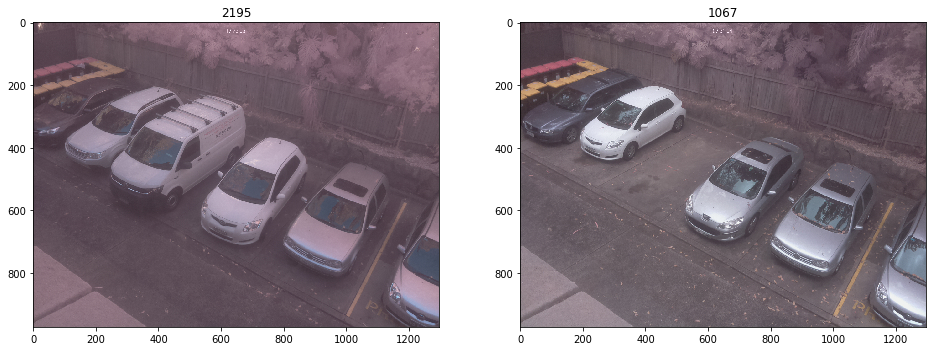

In [7]:
BASE_PATH=r'image\data'

full_list = glob.glob(os.path.join(BASE_PATH, r'Full\*.jpg'))
free_list = glob.glob(os.path.join(BASE_PATH, r'Free\*.jpg'))

full_img = img_to_array(load_img(full_list[0]), dtype=np.uint8)
free_img = img_to_array(load_img(free_list[0]), dtype=np.uint8)

fig, ax = plt.subplots(1,2, figsize=(16,16))
ax = ax.ravel()

ax[0].set_title(len(full_list))
ax[0].imshow(full_img)

ax[1].set_title(len(free_list))
ax[1].imshow(free_img)

# DataGenerator

In [10]:
train_datagen = ImageDataGenerator(rotation_range=10,
                                   width_shift_range=0.1,
                                   height_shift_range=0.1,
                                   brightness_range=[0.8, 1.2],
                                   shear_range=0.01,
                                   zoom_range=[0.9, 1.1],
                                   validation_split=0.1,
                                   preprocessing_function=preprocess_input)

In [12]:
val_datagen = ImageDataGenerator(validation_split=0.1,
                                 preprocessing_function=preprocess_input)

In [13]:
train_gen = train_datagen.flow_from_directory(BASE_PATH,
                                              target_size=(224,224),
                                              classes=['Full','Free'],
                                              class_mode='categorical',
                                              batch_size=32,
                                              shuffle=True,
                                              subset='training')

Found 2937 images belonging to 2 classes.


In [14]:
val_gen = val_datagen.flow_from_directory(BASE_PATH,
                                          target_size=(224,224),
                                          classes=['Full','Free'],
                                          class_mode='categorical',
                                          batch_size=32,
                                          shuffle=False,
                                          subset='validation')

Found 325 images belonging to 2 classes.


In [15]:
print(val_gen.class_indices)

{'Full': 0, 'Free': 1}


# Load Model for Transfer Learning

In [16]:
base_model = MobileNetV2(input_shape=(224,224,3),
                         weights='imagenet',
                         include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)
output = Dense(2,
               activation='softmax')(x)

model = Model(inputs=base_model.input,
              outputs=output)

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['acc'])
model.summary()

9412608/9406464 [==============================] - 14s 1us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________

# Switch Layers to be Trainable

In [17]:
for layer in model.layers:
    layer.trainable = True

# Train

In [18]:
history = model.fit_generator(train_gen,
                              validation_data=val_gen,
                              epochs=10,
                              callbacks=[ModelCheckpoint(r'source\Parking_Space_Finder\model.h5',
                                                         monitor='val_acc',
                                                         save_best_only=True,
                                                         verbose=1)])


Epoch 1/10
92/92 [==============================] - 1754s 19s/step - loss: 0.1258 - acc: 0.9629 - val_loss: 0.8828 - val_acc: 0.9015

Epoch 00001: val_acc improved from -inf to 0.90154, saving model to source\Parking_Space_Finder\model.h5
Epoch 2/10
92/92 [==============================] - 1722s 19s/step - loss: 0.0290 - acc: 0.9922 - val_loss: 0.0000e+00 - val_acc: 0.7631

Epoch 00002: val_acc did not improve from 0.90154
Epoch 3/10
92/92 [==============================] - 1714s 19s/step - loss: 0.0202 - acc: 0.9942 - val_loss: 2.1458e-07 - val_acc: 0.6246

Epoch 00003: val_acc did not improve from 0.90154
Epoch 4/10
92/92 [==============================] - 1728s 19s/step - loss: 0.0197 - acc: 0.9959 - val_loss: 5.0383 - val_acc: 0.9415

Epoch 00004: val_acc improved from 0.90154 to 0.94154, saving model to source\Parking_Space_Finder\model.h5
Epoch 5/10
92/92 [==============================] - 1716s 19s/step - loss: 0.0149 - acc: 0.9946 - val_loss: 4.1933 - val_acc: 0.9662

Epoch 00

# Ccreate New Model

In [19]:
model = load_model(r'source\Parking_Space_Finder\model.h5')

last_weight = model.layers[-1].get_weights()[0] # (1280, 2)

new_model = Model(inputs=model.input,
                  outputs=(model.layers[-3].output, # the layer just before GAP, using spatial features
                           model.layers[-1].output))

new_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
____________________________________________________________________________________________

# Normal Prediction

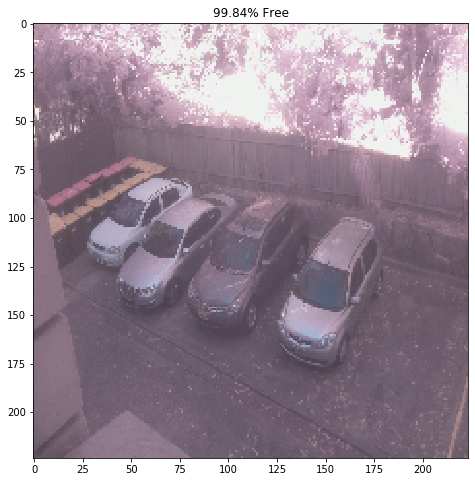

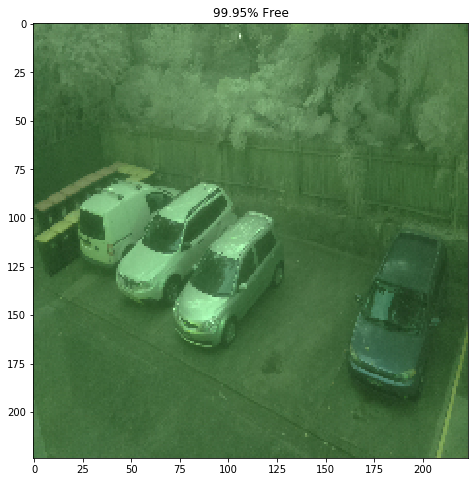

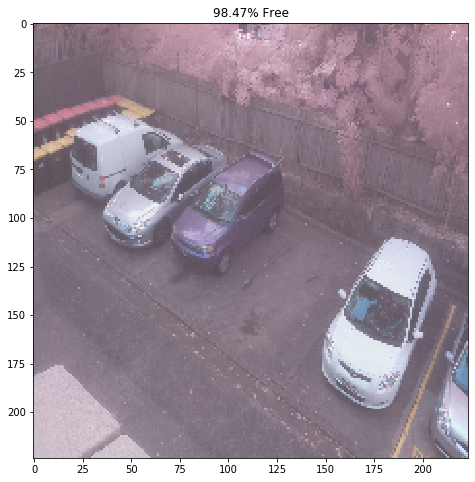

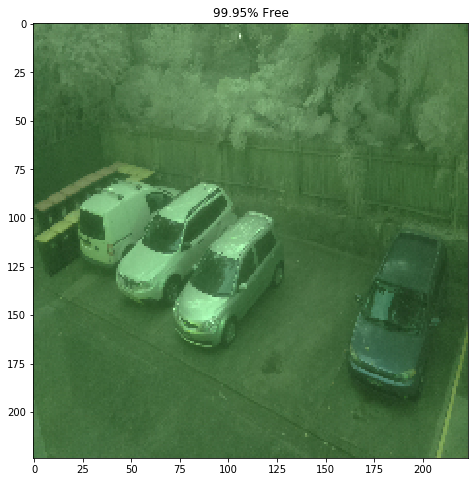

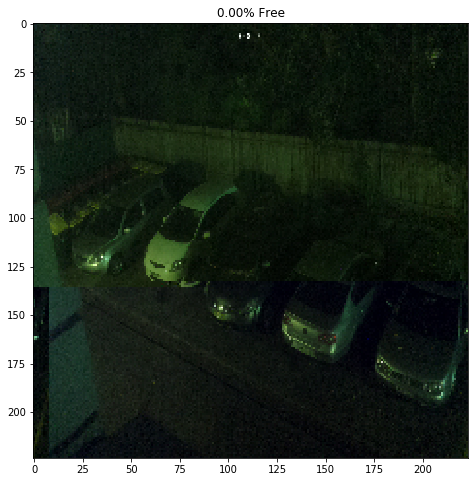

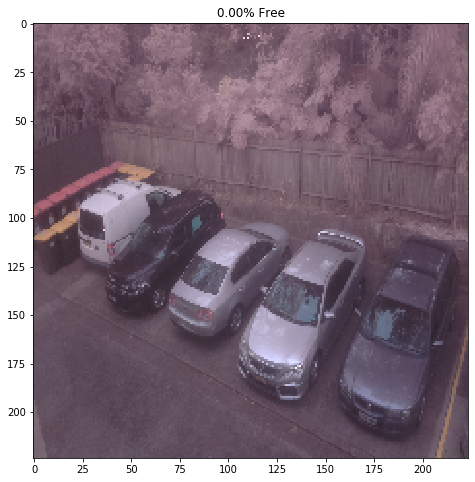

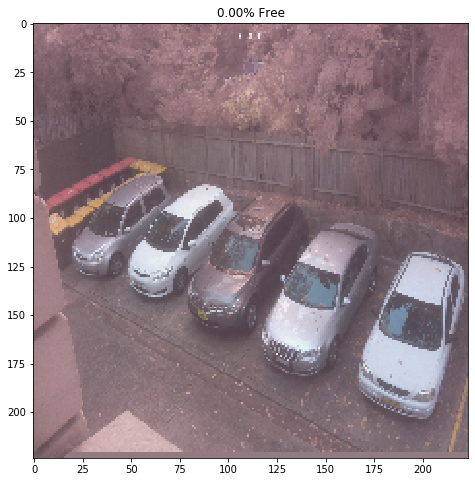

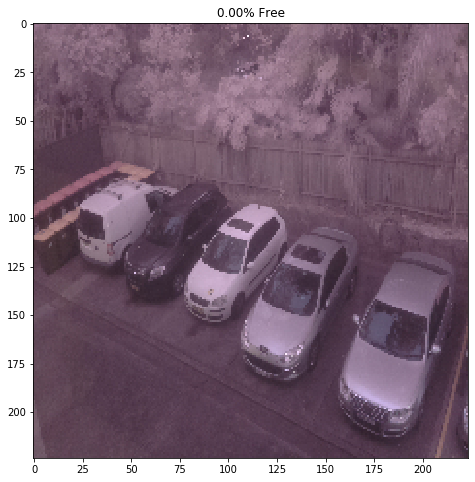

In [24]:
parking_list=['Free\img_129173058.jpg',
              'Free\img_815061601.jpg',
              'Free\img_723080007.jpg',
              'Free\img_815061601.jpg',
              'Full\img_127040601.jpg',
              'Full\img_809172559.jpg',
              'Full\img_129063058.jpg',
              'Full\img_822174600.jpg']

for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(BASE_PATH, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)
    
    plt.figure(figsize=(8,8))
    plt.title('%.2f%% Free' % (pred[0][1]*100))
    plt.imshow(test_img.astype(np.uint8))

# Draw Activation Map

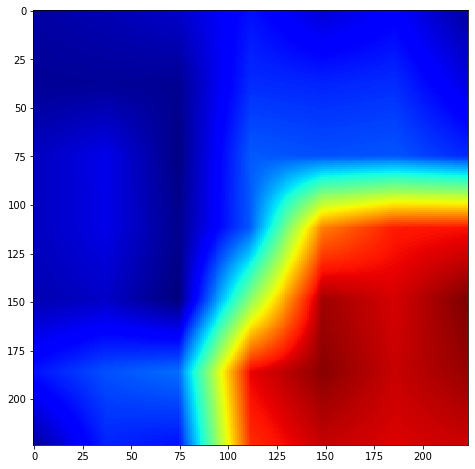

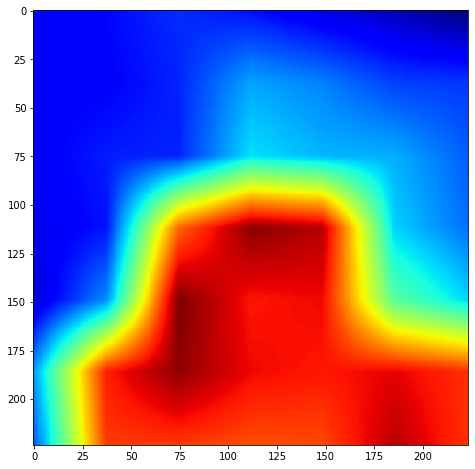

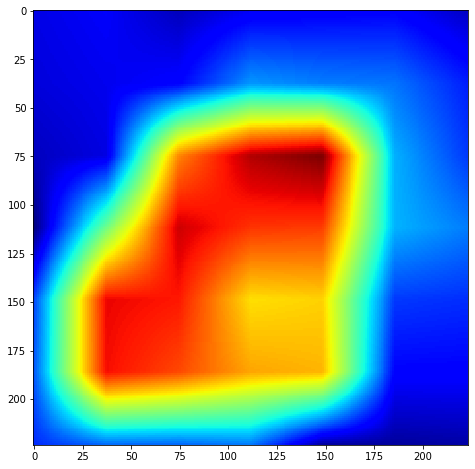

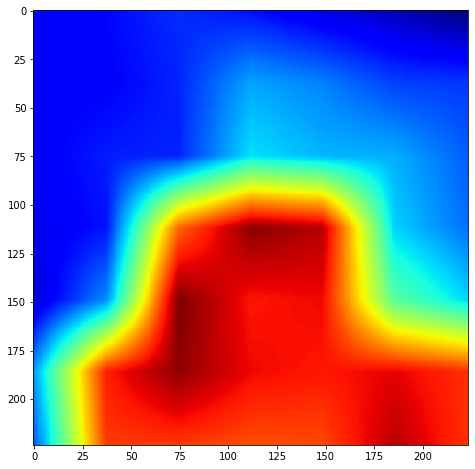

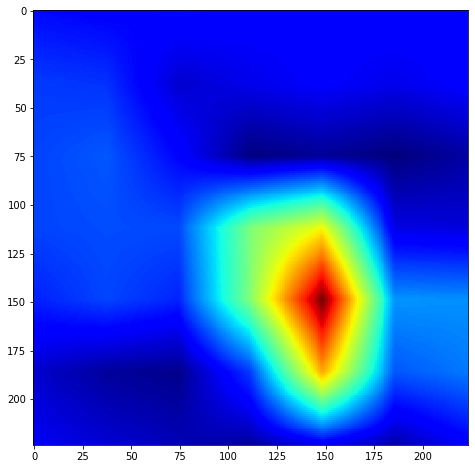

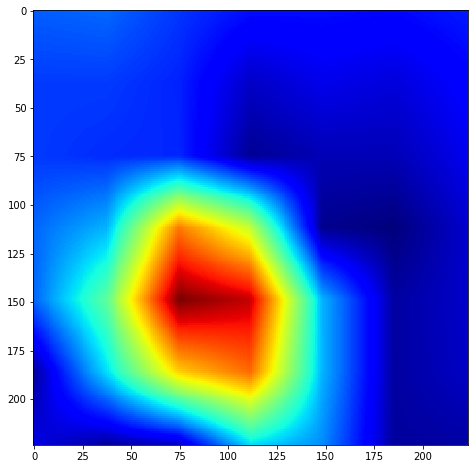

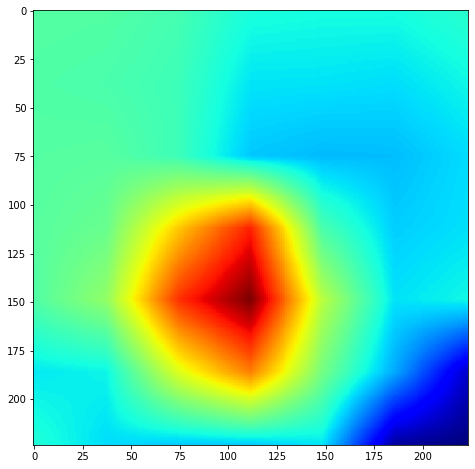

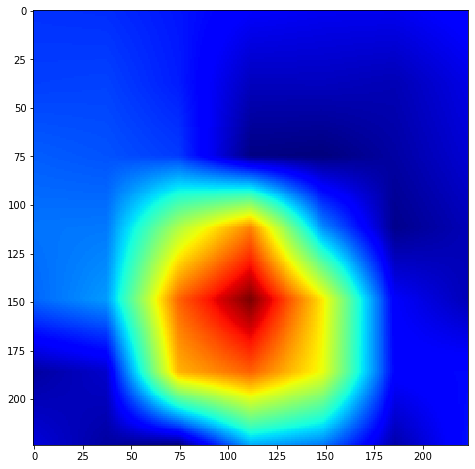

In [25]:
for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(BASE_PATH, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)

    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280)
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    
    plt.figure(figsize=(8,8))
    plt.imshow(final_output, cmap='jet')

# Result

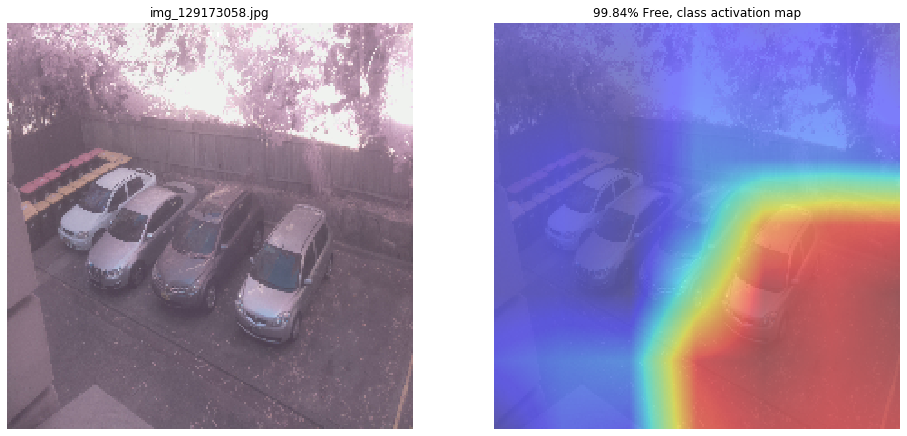

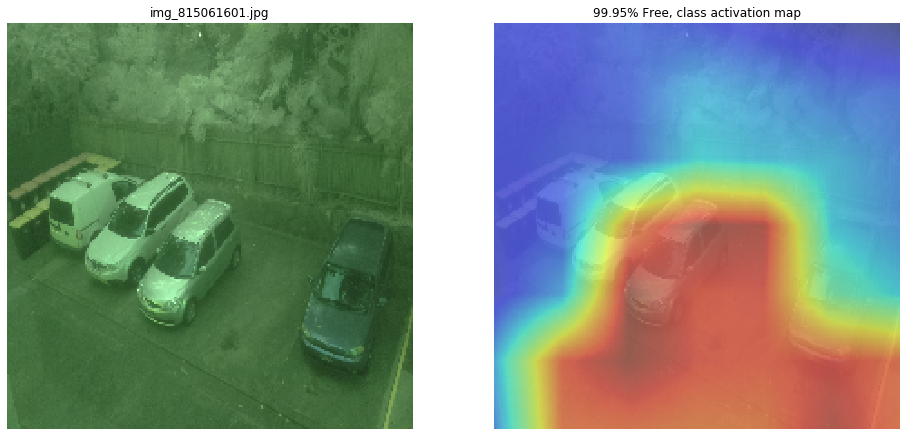

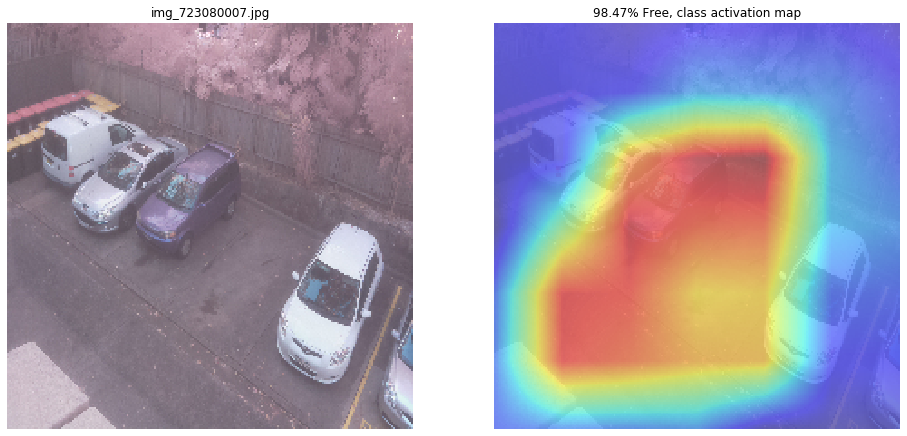

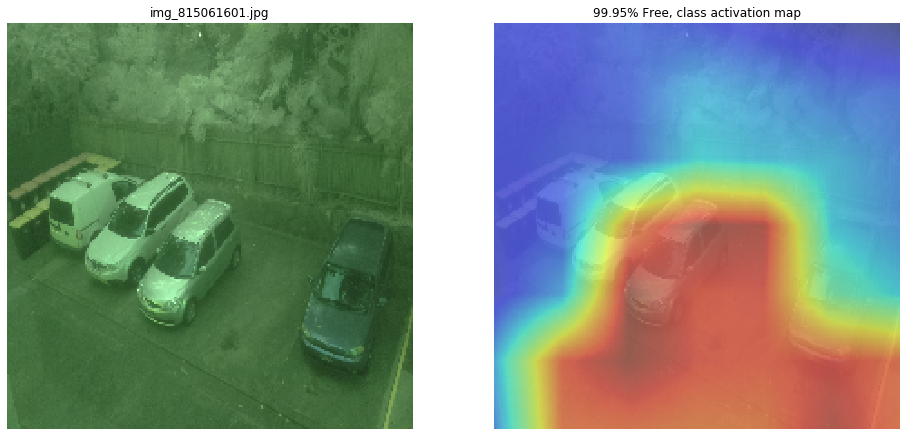

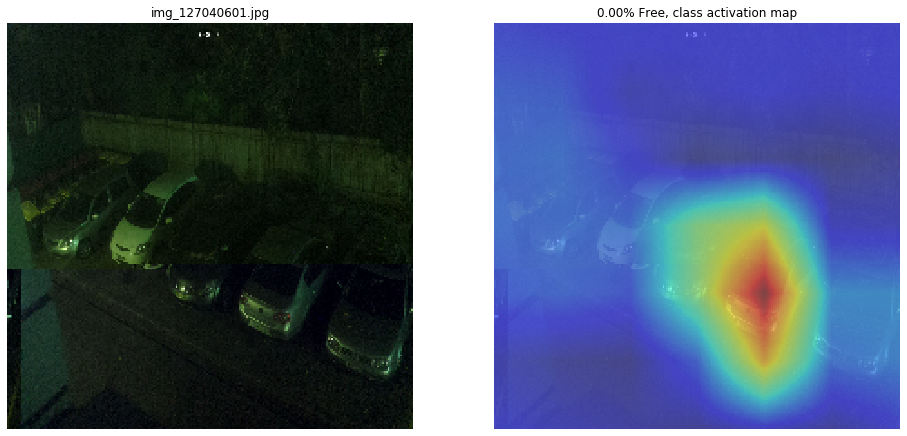

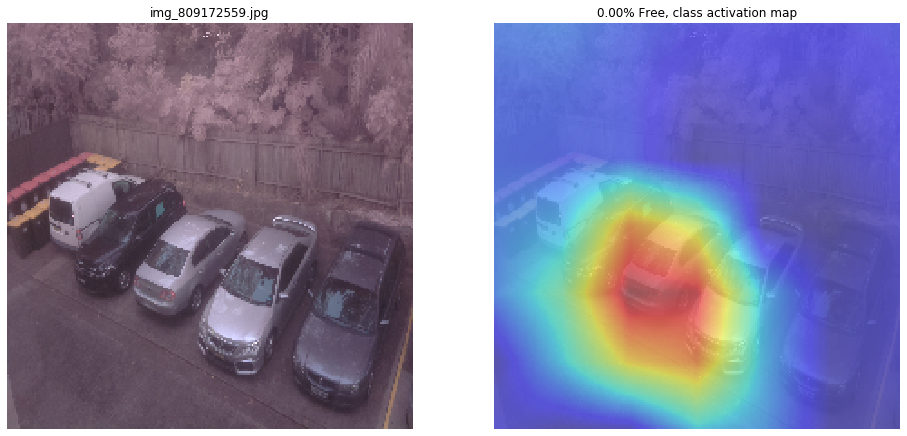

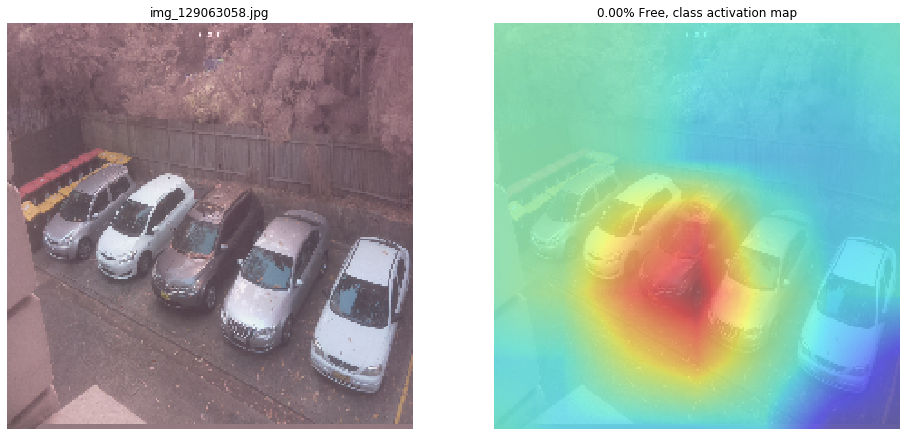

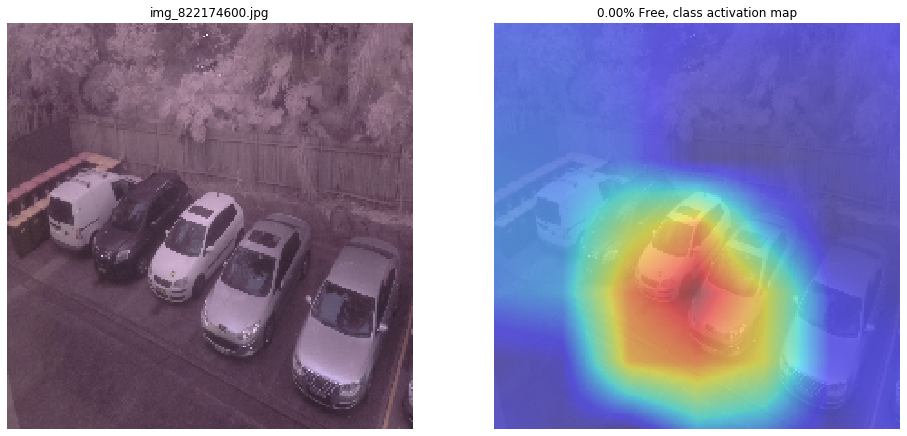

In [28]:
for parking in parking_list:
    test_img = img_to_array(load_img(os.path.join(BASE_PATH, parking), target_size=(224, 224)))
    test_input = preprocess_input(np.expand_dims(test_img.copy(), axis=0))
    pred = model.predict(test_input)

    last_conv_output, pred = new_model.predict(test_input)

    last_conv_output = np.squeeze(last_conv_output) # (7,7, 1280)
    feature_activation_maps = scipy.ndimage.zoom(last_conv_output, (32, 32, 1), order=1) 
    # (7,7,1280) -> (224,224,1280)

    pred_class = np.argmax(pred) # 0: Full, 1:Free
    predicted_class_weights = last_weight[:, pred_class] # (1280, 1)

    final_output = np.dot(feature_activation_maps.reshape((224*224,1280)), predicted_class_weights).reshape(224,224)
    # (224*224, 1280) dot_product(1280, 1) = (224*224, 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2)
    fig.set_size_inches(16, 20)

    ax[0].imshow(test_img.astype(np.uint8))
    ax[0].set_title(parking.split('\\')[1])
    ax[0].axis('off')

    ax[1].imshow(test_img.astype(np.uint8), alpha=0.5)
    ax[1].imshow(final_output, cmap='jet', alpha=0.5)
    ax[1].set_title('%.2f%% Free, class activation map' % (pred[0][1]*100))
    ax[1].axis('off')
    plt.show()